In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='1'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split2-slup15/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split2-slup15/', 'project_name': 'breakfast-split-2s', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
# loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcn-lenpsuedo-full-supervised-split1/ms-tcn-best-model.wt")
# model.load_state_dict(loaded_file)

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [31]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [32]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)
            
            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                prior_probs_cur_vid = prior_probs[video_id]
                weakly_labels_masked = []
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    prob_class_masked = prob_class * torch.tensor(prior_probs_cur_vid[i], 
                                                                  dtype=prob_class.dtype, device=prob_class.device)
                    weakly_labels_masked.append(prob_class_masked)
                    
                weakly_labels_masked = torch.stack(weakly_labels_masked)
                weakly_labels_masked = weakly_labels_masked / torch.sum(weakly_labels_masked, dim=0)

                for i in range(len(weakly_labels_video)):
                    cur_l = weakly_labels_video[i]
                    prob_class = weakly_labels_masked[i]
                    expected_value_of_class = torch.argmax(prob_class)
                    new_index_label_pair_list.append((int(expected_value_of_class.item()),
                                                      weakly_labels_video[i])) 
                
                back_list = copy.deepcopy(new_index_label_pair_list)
                error_list = []
                if new_index_label_pair_list[0][0] > new_index_label_pair_list[1][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                for i in range(1, len(new_index_label_pair_list) - 1, 1):
                    err = 0
                    prev_ele = new_index_label_pair_list[i - 1]
                    cur_ele = new_index_label_pair_list[i]
                    next_ele = new_index_label_pair_list[i + 1]
                    if not (prev_ele[0] < cur_ele[0]):
                        err += 1
                    if not (cur_ele[0] < next_ele[0]):
                        err += 1
                    error_list.append(err)

                if new_index_label_pair_list[-1][0] < new_index_label_pair_list[-2][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                if error_list[0] == 1 and error_list[1] == 1:
                    new_index = new_index_label_pair_list[1][0] // 2
                    new_index_label_pair_list[0] = (new_index, new_index_label_pair_list[0][1])
                    error_list[0] = 0
                    error_list[1] = 0
                    
                if error_list[-1] == 1 and error_list[-2] == 1:
                    new_index = (new_index_label_pair_list[-2][0] + weakly_labels_masked.shape[1]) // 2
                    new_index_label_pair_list[-1] = (new_index, new_index_label_pair_list[-1][1])
                    error_list[-1] = 0
                    error_list[-2] = 0
                    
                start_flag = False
                start_index = -1
                end_index = -1
                for i in range(1, len(error_list) - 1):
                    if error_list[i] == 1 and error_list[i + 1] == 2:
                        start_flag = True
                        start_index = i
                        
                    if (start_flag is True) and (error_list[i] == 2 or error_list[i + 1] == 1):
                        start_flag = False
                        end_index = i + 1
                        
                        num_div = end_index - start_index - 1
                        increm = (new_index_label_pair_list[end_index][0] - \
                                  new_index_label_pair_list[start_index][0]) // num_div
                        value = list(range(new_index_label_pair_list[start_index][0], 
                                           new_index_label_pair_list[end_index][0], increm))
                        count = 0
                        for ch_i in range(start_index + 1, end_index):
                            old_ele = new_index_label_pair_list[ch_i]
                            new_ele = (value[count], old_ele[1])
                            new_index_label_pair_list[ch_i] = new_ele
                            count += 1
                    
                final_list = new_index_label_pair_list
                is_valid_list = True
                for i in range(1, len(final_list) - 1, 1):
                    cur_ele = final_list[i]
                    
                    if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
                        is_valid_list  = False

                if is_valid_list == False:
                    print(f"Could not find expected solution for video {video_id}")
                    print(final_list)
                    print(back_list)
                    print(error_list)
                    new_selected_frame_dict[video_id + ".txt"] = selected_frames_dict[video_id + ".txt"]
                else:
                
                    label_name_final_list = []
                    for ele in final_list:
                        label_name_final_list.append((ele[0], label_id_to_label_name[ele[1]]))
                    new_selected_frame_dict[video_id + ".txt"] = label_name_final_list
                
        return new_selected_frame_dict

In [33]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [34]:
# selected_frames_dict = change_selected_frames(model)
# get_new_selected_frame_acc(selected_frames_dict)

In [27]:
# Initialize Expection Boundaries
# print("Calculating Expectation")
# correct = 0.0
# total = 0.0
# model.eval()
# for i, item in enumerate(trainloader):
#     with torch.no_grad():
#         item_0 = item[0].to(device)
#         item_1 = item[1].to(device)
#         item_2 = item[2].to(device)
#         src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
#         src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

#         middle_pred, predictions = model(item_0, src_mask_mse)
#         prob = torch.softmax(predictions[-1], dim=1)
#         prob = prob.permute(0, 2, 1)
#         calculate_element_probb(prob, item_1, item[4])

#         if i % 10 == 0:
#             print(f"Completed iter {i}")

# get_boundary_err()

In [28]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split2-slup15/'

In [36]:
!ls /mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split2-slup15/

ms-tcn-emmax-best-model.wt  ms-tcn-initial-25-epochs.wt
ms-tcn-emmax-last-model.wt


In [35]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(25, 150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                            max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 25, Iteration 0, Current loss 2.3112359046936035 Accuracy 66.56409486640648
Training:: Epoch 25, Iteration 10, Current loss 3.308283805847168 Accuracy 57.179375611878605
Training:: Epoch 25, Iteration 20, Current loss 2.2027230262756348 Accuracy 71.94739448632586
Training:: Epoch 25, Iteration 30, Current loss 3.3358325958251953 Accuracy 59.08878504672897
Training:: Epoch 25, Iteration 40, Current loss 2.6516690254211426 Accuracy 58.13093644418946
Training:: Epoch 25, Iteration 50, Current loss 2.682396173477173 Accuracy 65.72937131630648
Training:: Epoch 25, Iteration 60, Current loss 3.719512701034546 Accuracy 47.60024734814251
Training:: Epoch 25, Iteration 70, Current loss 2.6149399280548096 Accuracy 59.7769547667596
Training:: Epoch 25, Iteration 80, Current loss 2.610637903213501 Accuracy 59.45417515274949
Training:: Epoch 25, Iteration 90, Current loss 3.0873522758483887 Accuracy 64.65588154647655
Training:: Epoch 25, Iteration 100, Current los

Training:: Epoch 29, Iteration 50, Current loss 1.0604662324247784 Accuracy 71.55172413793103
Training:: Epoch 29, Iteration 60, Current loss 1.7307203784962628 Accuracy 72.40084038963519
Training:: Epoch 29, Iteration 70, Current loss 1.2507676178023759 Accuracy 64.24065100118862
Training:: Epoch 29, Iteration 80, Current loss 1.7603079247573108 Accuracy 55.421967111386905
Training:: Epoch 29, Iteration 90, Current loss 2.129927713833119 Accuracy 69.53260242354298
Training:: Epoch 29, Iteration 100, Current loss 2.6844662124125147 Accuracy 52.267337405677324
Training:: Epoch 29, Iteration 110, Current loss 1.6559681727317375 Accuracy 67.9087816287476
Training:: Epoch 29, Iteration 120, Current loss 1.6306890131294125 Accuracy 64.34749265050488
Training:: Epoch 29, Iteration 130, Current loss 1.711145207981205 Accuracy 63.774962422160186
Training:: Epoch 29, Iteration 140, Current loss 1.416694764951668 Accuracy 70.26651446721921
Training:: Epoch 29, Iteration 150, Current loss 1.45048

Training:: Epoch 33, Iteration 110, Current loss 1.0282313663577 Accuracy 58.3607658716829
Training:: Epoch 33, Iteration 120, Current loss 1.510437864895064 Accuracy 67.13483146067416
Training:: Epoch 33, Iteration 130, Current loss 2.1919363498928797 Accuracy 62.353382753120016
Training:: Epoch 33, Iteration 140, Current loss 1.4866315401994643 Accuracy 54.5111537697756
Training:: Epoch 33, Iteration 150, Current loss 1.0887347071679963 Accuracy 67.11250134829037
Calculating Validation Data Accuracy
Validation:: Epoch 33, Probability Accuracy 54.46265070224137
Starting Training
Training:: Epoch 34, Iteration 0, Current loss 0.9981233568347604 Accuracy 65.23156724712857
Training:: Epoch 34, Iteration 10, Current loss 0.9054752200249921 Accuracy 66.09128773240586
Training:: Epoch 34, Iteration 20, Current loss 0.8096024686747021 Accuracy 69.93119112833189
Training:: Epoch 34, Iteration 30, Current loss 1.011462879946302 Accuracy 78.84615384615384
Training:: Epoch 34, Iteration 40, Curr

Training:: Epoch 38, Iteration 80, Current loss 1.0183539952979315 Accuracy 64.97878746407554
Training:: Epoch 38, Iteration 90, Current loss 0.9385099000318481 Accuracy 66.18895966029724
Training:: Epoch 38, Iteration 100, Current loss 1.7861761861799592 Accuracy 65.67349252462269
Training:: Epoch 38, Iteration 110, Current loss 1.3396738907522665 Accuracy 65.20406741886056
Training:: Epoch 38, Iteration 120, Current loss 0.7486279986558009 Accuracy 68.42733512384363
Training:: Epoch 38, Iteration 130, Current loss 0.985382230437795 Accuracy 71.75365637119761
Training:: Epoch 38, Iteration 140, Current loss 1.0827536699523579 Accuracy 65.29991843997924
Training:: Epoch 38, Iteration 150, Current loss 1.7301436559417167 Accuracy 45.82833133253301
Calculating Validation Data Accuracy
Validation:: Epoch 38, Probability Accuracy 48.1144094129345
Starting Training
Training:: Epoch 39, Iteration 0, Current loss 5.305832548023728 Accuracy 57.719836400818
Training:: Epoch 39, Iteration 10, Cu

Training:: Epoch 43, Iteration 50, Current loss 1.0763526744888736 Accuracy 56.848453067645515
Training:: Epoch 43, Iteration 60, Current loss 0.9009913924901913 Accuracy 59.95256106160652
Training:: Epoch 43, Iteration 70, Current loss 0.6561363568120949 Accuracy 62.41438356164384
Training:: Epoch 43, Iteration 80, Current loss 0.7566178740822147 Accuracy 50.298616168973055
Training:: Epoch 43, Iteration 90, Current loss 0.6494374772146226 Accuracy 64.25763531902027
Training:: Epoch 43, Iteration 100, Current loss 1.0764087764785994 Accuracy 56.57075204612138
Training:: Epoch 43, Iteration 110, Current loss 0.8928933571954774 Accuracy 65.10225885225886
Training:: Epoch 43, Iteration 120, Current loss 0.9044481844003915 Accuracy 63.96292450290373
Training:: Epoch 43, Iteration 130, Current loss 0.7172390475773941 Accuracy 66.47859922178988
Training:: Epoch 43, Iteration 140, Current loss 0.7010738501433554 Accuracy 62.15847710944465
Training:: Epoch 43, Iteration 150, Current loss 0.74

Training:: Epoch 47, Iteration 110, Current loss 0.8605906341440792 Accuracy 61.921995918838796
Training:: Epoch 47, Iteration 120, Current loss 0.762801988384514 Accuracy 49.0034295939162
Training:: Epoch 47, Iteration 130, Current loss 0.525698754753806 Accuracy 61.511985248924404
Training:: Epoch 47, Iteration 140, Current loss 0.7482943683651275 Accuracy 69.8077513038143
Training:: Epoch 47, Iteration 150, Current loss 0.647496935121515 Accuracy 61.91465841255803
Calculating Validation Data Accuracy
Validation:: Epoch 47, Probability Accuracy 55.08410324398227
Starting Training
Training:: Epoch 48, Iteration 0, Current loss 0.6174856016000821 Accuracy 63.49437912983781
Training:: Epoch 48, Iteration 10, Current loss 0.6315333868835629 Accuracy 68.24477233638092
Training:: Epoch 48, Iteration 20, Current loss 0.580739724708218 Accuracy 65.55229397695152
Training:: Epoch 48, Iteration 30, Current loss 0.6997522833908676 Accuracy 65.88360583850154
Training:: Epoch 48, Iteration 40, Cu

Training:: Epoch 52, Iteration 80, Current loss 0.5463527575816267 Accuracy 66.8870523415978
Training:: Epoch 52, Iteration 90, Current loss 0.535193325861192 Accuracy 59.26329974972727
Training:: Epoch 52, Iteration 100, Current loss 0.5218000965485083 Accuracy 62.96407829640783
Training:: Epoch 52, Iteration 110, Current loss 0.6765970927632563 Accuracy 60.83379278171254
Training:: Epoch 52, Iteration 120, Current loss 0.6458530880681504 Accuracy 58.36750314362255
Training:: Epoch 52, Iteration 130, Current loss 0.6226615328855587 Accuracy 64.37040613766833
Training:: Epoch 52, Iteration 140, Current loss 0.7963528768369761 Accuracy 60.63278893757469
Training:: Epoch 52, Iteration 150, Current loss 0.5779510117297592 Accuracy 68.55130057803468
Calculating Validation Data Accuracy
Validation:: Epoch 52, Probability Accuracy 54.8839955255417
Starting Training
Training:: Epoch 53, Iteration 0, Current loss 0.5023833146331758 Accuracy 57.34588942168814
Training:: Epoch 53, Iteration 10, 

Training:: Epoch 57, Iteration 50, Current loss 6.885093098806506 Accuracy 43.16026264591439
Training:: Epoch 57, Iteration 60, Current loss 2.7762814786467014 Accuracy 66.52325675785372
Training:: Epoch 57, Iteration 70, Current loss 2.093266588499585 Accuracy 64.27678199249688
Training:: Epoch 57, Iteration 80, Current loss 1.4189804393234597 Accuracy 61.98725055432372
Training:: Epoch 57, Iteration 90, Current loss 1.166567852796174 Accuracy 58.704871683340585
Training:: Epoch 57, Iteration 100, Current loss 1.0719235690667595 Accuracy 62.88122506755887
Training:: Epoch 57, Iteration 110, Current loss 1.7019779343713335 Accuracy 57.27239532619279
Training:: Epoch 57, Iteration 120, Current loss 1.0747543642019461 Accuracy 59.796025353857885
Training:: Epoch 57, Iteration 130, Current loss 1.193097452481278 Accuracy 71.36154823575409
Training:: Epoch 57, Iteration 140, Current loss 1.2312824191368688 Accuracy 68.22608921498605
Training:: Epoch 57, Iteration 150, Current loss 1.054923

Training:: Epoch 61, Iteration 100, Current loss 0.6195406711606146 Accuracy 63.180531975099036
Training:: Epoch 61, Iteration 110, Current loss 0.4187495200372012 Accuracy 62.683915385042475
Training:: Epoch 61, Iteration 120, Current loss 0.4024215949065362 Accuracy 70.56171188383645
Training:: Epoch 61, Iteration 130, Current loss 0.4646827966825175 Accuracy 72.51840465981716
Training:: Epoch 61, Iteration 140, Current loss 0.427180706441045 Accuracy 66.39082058414465
Training:: Epoch 61, Iteration 150, Current loss 0.3410070700650788 Accuracy 73.46576153811108
Calculating Validation Data Accuracy
Validation:: Epoch 61, Probability Accuracy 55.091664249906785
Starting Training
Training:: Epoch 62, Iteration 0, Current loss 0.35154360572531984 Accuracy 62.41886768202558
Training:: Epoch 62, Iteration 10, Current loss 0.73392403902897 Accuracy 63.26302195436935
Training:: Epoch 62, Iteration 20, Current loss 0.31229471934109837 Accuracy 62.61057782796913
Training:: Epoch 62, Iteration

Training:: Epoch 66, Iteration 70, Current loss 0.3781808894252786 Accuracy 71.4808105206656
Training:: Epoch 66, Iteration 80, Current loss 0.3767962634968294 Accuracy 58.32690596262237
Training:: Epoch 66, Iteration 90, Current loss 0.4568493266039351 Accuracy 61.16725097958342
Training:: Epoch 66, Iteration 100, Current loss 0.4980518449288141 Accuracy 60.96142663306843
Training:: Epoch 66, Iteration 110, Current loss 0.37214415262103395 Accuracy 67.30031773857785
Training:: Epoch 66, Iteration 120, Current loss 0.5710518418992562 Accuracy 59.92750704792589
Training:: Epoch 66, Iteration 130, Current loss 0.5261021714313947 Accuracy 68.8819083145185
Training:: Epoch 66, Iteration 140, Current loss 0.32060475453295906 Accuracy 72.93399168399168
Training:: Epoch 66, Iteration 150, Current loss 0.5576918313106228 Accuracy 60.94060812730889
Calculating Validation Data Accuracy
Validation:: Epoch 66, Probability Accuracy 54.754836972283215
Starting Training
Training:: Epoch 67, Iteration

Training:: Epoch 71, Iteration 40, Current loss 1.4657663732786197 Accuracy 63.2750054007345
Training:: Epoch 71, Iteration 50, Current loss 1.6366482381646832 Accuracy 70.71368831892947
Training:: Epoch 71, Iteration 60, Current loss 1.8272710020676106 Accuracy 66.74848298902297
Training:: Epoch 71, Iteration 70, Current loss 1.6038850241901377 Accuracy 65.87745147850828
Training:: Epoch 71, Iteration 80, Current loss 1.2135042381046128 Accuracy 60.34874905231236
Training:: Epoch 71, Iteration 90, Current loss 1.0050030933431002 Accuracy 74.08036589349885
Training:: Epoch 71, Iteration 100, Current loss 0.9244057478148082 Accuracy 58.12360178970917
Training:: Epoch 71, Iteration 110, Current loss 0.7248142110260163 Accuracy 70.01815331297962
Training:: Epoch 71, Iteration 120, Current loss 0.9082684375577625 Accuracy 74.86484636967084
Training:: Epoch 71, Iteration 130, Current loss 1.1529957809391105 Accuracy 57.28077945084145
Training:: Epoch 71, Iteration 140, Current loss 1.033284

Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Total correct pivots labels selected =  59.06242747737294
Calculating Expectation
Epoch 75 iter 0
Epoch 75 iter 10
Epoch 75 iter 20
Epoch 75 iter 30
Epoch 75 iter 40
Epoch 75 iter 50
Epoch 75 iter 60
Epoch 75 iter 70
Epoch 75 iter 80
Epoch 75 iter 90
Epoch 75 iter 100
Epoch 75 iter 110
Epoch 75 iter 120
Epoch 75 iter 130
Epoch 75 iter 140
Epoch 75 iter 150
Train Boundary avergage error = 284.544
Train From boundary avergage accuracy = 60.382
Starting Training
Training:: Epoch 76, Iteration 0, Current loss 0.6159304305017264 Accuracy 51.35705245394459
Training:: Epoch 76, Iteration 10, Current loss 0.7708491105487004 Accuracy 64.86236052662059
Training:: Epoch 76, Iteration 20, Current loss 0.66525

Training:: Epoch 80, Iteration 100, Current loss 0.5027113806873797 Accuracy 69.03686673782741
Training:: Epoch 80, Iteration 110, Current loss 0.700585669525337 Accuracy 53.193257359924026
Training:: Epoch 80, Iteration 120, Current loss 0.5243151323637433 Accuracy 69.88748241912799
Training:: Epoch 80, Iteration 130, Current loss 0.46741881958805676 Accuracy 53.513710770514024
Training:: Epoch 80, Iteration 140, Current loss 0.5029759276717569 Accuracy 63.207864790249815
Training:: Epoch 80, Iteration 150, Current loss 0.42539789357325736 Accuracy 60.47781029981805
Calculating Validation Data Accuracy
Validation:: Epoch 80, Probability Accuracy 55.074263578738034
Calculating Expectation
Epoch 80 iter 0
Epoch 80 iter 10
Epoch 80 iter 20
Epoch 80 iter 30
Epoch 80 iter 40
Epoch 80 iter 50
Epoch 80 iter 60
Epoch 80 iter 70
Epoch 80 iter 80
Epoch 80 iter 90
Epoch 80 iter 100
Epoch 80 iter 110
Epoch 80 iter 120
Epoch 80 iter 130
Epoch 80 iter 140
Epoch 80 iter 150
Train Boundary avergage e

Training:: Epoch 85, Iteration 70, Current loss 0.45740793882524594 Accuracy 47.755786648775576
Training:: Epoch 85, Iteration 80, Current loss 0.3960061901739247 Accuracy 58.97035881435257
Training:: Epoch 85, Iteration 90, Current loss 0.34145713550447493 Accuracy 63.49041349041349
Training:: Epoch 85, Iteration 100, Current loss 0.38020000653610136 Accuracy 59.317539915845295
Training:: Epoch 85, Iteration 110, Current loss 0.3833300662701826 Accuracy 54.09185803757829
Training:: Epoch 85, Iteration 120, Current loss 0.4516252113898742 Accuracy 71.68159818762228
Training:: Epoch 85, Iteration 130, Current loss 0.38309450409912643 Accuracy 62.468953480566555
Training:: Epoch 85, Iteration 140, Current loss 0.4169663443723386 Accuracy 63.983050847457626
Training:: Epoch 85, Iteration 150, Current loss 0.4850845158954535 Accuracy 64.26457341397503
Calculating Validation Data Accuracy
Validation:: Epoch 85, Probability Accuracy 53.89485022993744
Calculating Expectation
Epoch 85 iter 0
E

Training:: Epoch 90, Iteration 40, Current loss 0.533905750262825 Accuracy 64.76745334254962
Training:: Epoch 90, Iteration 50, Current loss 0.27560338704280807 Accuracy 65.90374250360586
Training:: Epoch 90, Iteration 60, Current loss 0.5664990172395233 Accuracy 69.21257773495664
Training:: Epoch 90, Iteration 70, Current loss 0.7778380703858879 Accuracy 48.49646342909077
Training:: Epoch 90, Iteration 80, Current loss 0.3159685275837333 Accuracy 57.70971914264597
Training:: Epoch 90, Iteration 90, Current loss 0.4696166839076369 Accuracy 60.82651519099484
Training:: Epoch 90, Iteration 100, Current loss 0.4897836668495078 Accuracy 66.60164224470354
Training:: Epoch 90, Iteration 110, Current loss 0.3625245272546638 Accuracy 61.516754850088184
Training:: Epoch 90, Iteration 120, Current loss 0.36870526100118395 Accuracy 58.25337058180493
Training:: Epoch 90, Iteration 130, Current loss 0.4260469673975278 Accuracy 69.07355978067365
Training:: Epoch 90, Iteration 140, Current loss 0.422

Training:: Epoch 94, Iteration 90, Current loss 0.2456149090192964 Accuracy 67.16824402532852
Training:: Epoch 94, Iteration 100, Current loss 0.2799190142575264 Accuracy 60.67516494779322
Training:: Epoch 94, Iteration 110, Current loss 0.28852667638380225 Accuracy 55.691755153029355
Training:: Epoch 94, Iteration 120, Current loss 0.38487533527863227 Accuracy 74.94270435446906
Training:: Epoch 94, Iteration 130, Current loss 0.26637652206206336 Accuracy 67.69854761265694
Training:: Epoch 94, Iteration 140, Current loss 0.25835696304309214 Accuracy 73.06592163906073
Training:: Epoch 94, Iteration 150, Current loss 0.2405528727955834 Accuracy 67.02965708989805
Calculating Validation Data Accuracy
Validation:: Epoch 94, Probability Accuracy 56.32462609272072
Starting Training
Training:: Epoch 95, Iteration 0, Current loss 0.3263205411944224 Accuracy 58.64102427880784
Training:: Epoch 95, Iteration 10, Current loss 0.3614032695707979 Accuracy 64.6927374301676
Training:: Epoch 95, Iterati

Training:: Epoch 99, Iteration 60, Current loss 0.2746436671333411 Accuracy 69.07176588991251
Training:: Epoch 99, Iteration 70, Current loss 0.2656971585208595 Accuracy 54.89437081747802
Training:: Epoch 99, Iteration 80, Current loss 0.22918384244315554 Accuracy 66.3111072724132
Training:: Epoch 99, Iteration 90, Current loss 0.30572270045223693 Accuracy 64.75424486148347
Training:: Epoch 99, Iteration 100, Current loss 0.2187934409291602 Accuracy 51.187039764359355
Training:: Epoch 99, Iteration 110, Current loss 0.25648000672686194 Accuracy 72.76984312807305
Training:: Epoch 99, Iteration 120, Current loss 0.29222304208495337 Accuracy 63.74058863791923
Training:: Epoch 99, Iteration 130, Current loss 0.4435602911836065 Accuracy 59.66537966537967
Training:: Epoch 99, Iteration 140, Current loss 0.2714475457866567 Accuracy 60.03928866832093
Training:: Epoch 99, Iteration 150, Current loss 0.2514039784892472 Accuracy 67.49458170784568
Calculating Validation Data Accuracy
Validation:: 

Training:: Epoch 104, Iteration 20, Current loss 0.3996726554787937 Accuracy 60.79285790200871
Training:: Epoch 104, Iteration 30, Current loss 0.32799103824782083 Accuracy 65.20698731754008
Training:: Epoch 104, Iteration 40, Current loss 0.35733691005233276 Accuracy 63.14655172413793
Training:: Epoch 104, Iteration 50, Current loss 0.30899558004443367 Accuracy 61.33936779577116
Training:: Epoch 104, Iteration 60, Current loss 0.29809379041342066 Accuracy 66.67286591035894
Training:: Epoch 104, Iteration 70, Current loss 0.30975744951259765 Accuracy 68.28966880869996
Training:: Epoch 104, Iteration 80, Current loss 0.2835909188424769 Accuracy 63.78697022055087
Training:: Epoch 104, Iteration 90, Current loss 0.23320732498752655 Accuracy 49.51163278138755
Training:: Epoch 104, Iteration 100, Current loss 0.31427096082186035 Accuracy 66.38640321902588
Training:: Epoch 104, Iteration 110, Current loss 0.3142389076724168 Accuracy 60.58234054449271
Training:: Epoch 104, Iteration 120, Curr

Training:: Epoch 108, Iteration 60, Current loss 0.30429934203598463 Accuracy 60.24270965404818
Training:: Epoch 108, Iteration 70, Current loss 0.27664234464768656 Accuracy 53.72266170311773
Training:: Epoch 108, Iteration 80, Current loss 0.4165599464430399 Accuracy 65.45008183306055
Training:: Epoch 108, Iteration 90, Current loss 0.42503757445327617 Accuracy 67.5610345661107
Training:: Epoch 108, Iteration 100, Current loss 0.3170357636196973 Accuracy 52.89581128081053
Training:: Epoch 108, Iteration 110, Current loss 0.30543165067281963 Accuracy 70.77422345850718
Training:: Epoch 108, Iteration 120, Current loss 0.686111021363877 Accuracy 64.05489507699673
Training:: Epoch 108, Iteration 130, Current loss 0.5185222205859861 Accuracy 69.3158953722334
Training:: Epoch 108, Iteration 140, Current loss 0.3728127475016585 Accuracy 60.6042654028436
Training:: Epoch 108, Iteration 150, Current loss 0.3326369144199964 Accuracy 68.55251654802048
Calculating Validation Data Accuracy
Validat

Training:: Epoch 113, Iteration 20, Current loss 1.1955770204920495 Accuracy 74.97645211930926
Training:: Epoch 113, Iteration 30, Current loss 0.9132745200088064 Accuracy 63.79724535554132
Training:: Epoch 113, Iteration 40, Current loss 0.9547976217469551 Accuracy 64.49006622516556
Training:: Epoch 113, Iteration 50, Current loss 0.6601232415162146 Accuracy 61.00495399858457
Training:: Epoch 113, Iteration 60, Current loss 0.5991113814933036 Accuracy 66.8108504398827
Training:: Epoch 113, Iteration 70, Current loss 0.7637788131433232 Accuracy 59.68283366130339
Training:: Epoch 113, Iteration 80, Current loss 0.9372526867359056 Accuracy 63.51467194197164
Training:: Epoch 113, Iteration 90, Current loss 0.4849649019765515 Accuracy 68.301903189363
Training:: Epoch 113, Iteration 100, Current loss 0.591806923226346 Accuracy 67.21715446802992
Training:: Epoch 113, Iteration 110, Current loss 0.4142798484132101 Accuracy 67.98639034952058
Training:: Epoch 113, Iteration 120, Current loss 1.

Training:: Epoch 117, Iteration 150, Current loss 0.3443740169029198 Accuracy 60.6702518363064
Calculating Validation Data Accuracy
Validation:: Epoch 117, Probability Accuracy 55.463810746985956
Starting Training
Training:: Epoch 118, Iteration 0, Current loss 0.22150817206576529 Accuracy 61.828203950390446
Training:: Epoch 118, Iteration 10, Current loss 0.26280692731933974 Accuracy 73.7163192679207
Training:: Epoch 118, Iteration 20, Current loss 0.24860006633034712 Accuracy 69.78851963746223
Training:: Epoch 118, Iteration 30, Current loss 0.20928830080457972 Accuracy 66.25682336106841
Training:: Epoch 118, Iteration 40, Current loss 0.2663291690257542 Accuracy 60.647218613440415
Training:: Epoch 118, Iteration 50, Current loss 0.2756151552751162 Accuracy 63.82105263157895
Training:: Epoch 118, Iteration 60, Current loss 0.18339172892475522 Accuracy 61.57747721258453
Training:: Epoch 118, Iteration 70, Current loss 0.25505541985844205 Accuracy 63.85811018775008
Training:: Epoch 118

Training:: Epoch 122, Iteration 20, Current loss 0.3172679789220781 Accuracy 60.178456443749425
Training:: Epoch 122, Iteration 30, Current loss 0.2933455358708946 Accuracy 70.8461404627965
Training:: Epoch 122, Iteration 40, Current loss 0.20591650243567702 Accuracy 64.2581330244232
Training:: Epoch 122, Iteration 50, Current loss 0.23887717307950118 Accuracy 71.68538194269601
Training:: Epoch 122, Iteration 60, Current loss 0.24780076962773734 Accuracy 71.88486361709144
Training:: Epoch 122, Iteration 70, Current loss 0.23870426394664956 Accuracy 69.69238527483611
Training:: Epoch 122, Iteration 80, Current loss 0.29995767975249005 Accuracy 60.901719104768084
Training:: Epoch 122, Iteration 90, Current loss 0.22044774218190255 Accuracy 61.52740341419587
Training:: Epoch 122, Iteration 100, Current loss 0.22027339452430728 Accuracy 63.66556258155174
Training:: Epoch 122, Iteration 110, Current loss 0.23231619584882876 Accuracy 72.31599188120927
Training:: Epoch 122, Iteration 120, Cur

Training:: Epoch 126, Iteration 150, Current loss 0.29445393016279564 Accuracy 60.48403226881792
Calculating Validation Data Accuracy
Validation:: Epoch 126, Probability Accuracy 54.533703442847084
Starting Training
Training:: Epoch 127, Iteration 0, Current loss 0.21320201500311659 Accuracy 66.87835322457023
Training:: Epoch 127, Iteration 10, Current loss 0.20542902574231678 Accuracy 61.15494237680202
Training:: Epoch 127, Iteration 20, Current loss 0.3131901665558533 Accuracy 64.15724368217349
Training:: Epoch 127, Iteration 30, Current loss 0.21473611093123712 Accuracy 58.12439396038233
Training:: Epoch 127, Iteration 40, Current loss 0.2045074921633367 Accuracy 67.8195549128304
Training:: Epoch 127, Iteration 50, Current loss 0.27138541127047144 Accuracy 71.22155132373432
Training:: Epoch 127, Iteration 60, Current loss 0.2037956529147515 Accuracy 68.85507554798893
Training:: Epoch 127, Iteration 70, Current loss 0.2566556685828044 Accuracy 71.16797900262468
Training:: Epoch 127, 

Training:: Epoch 131, Iteration 110, Current loss 0.2079433598325556 Accuracy 63.475416145482534
Training:: Epoch 131, Iteration 120, Current loss 0.20218527869337047 Accuracy 60.303030303030305
Training:: Epoch 131, Iteration 130, Current loss 0.23130713230957298 Accuracy 66.02978364709188
Training:: Epoch 131, Iteration 140, Current loss 0.20482114679388588 Accuracy 55.11201629327902
Training:: Epoch 131, Iteration 150, Current loss 0.2905798065573737 Accuracy 60.18645462023581
Calculating Validation Data Accuracy
Validation:: Epoch 131, Probability Accuracy 53.95917056800762
Starting Training
Training:: Epoch 132, Iteration 0, Current loss 0.1888680479757505 Accuracy 67.78359017861351
Training:: Epoch 132, Iteration 10, Current loss 0.2750765299535488 Accuracy 69.5226586102719
Training:: Epoch 132, Iteration 20, Current loss 0.17750934611383698 Accuracy 70.19551740581784
Training:: Epoch 132, Iteration 30, Current loss 0.2791066740036121 Accuracy 64.52484796363413
Training:: Epoch 1

Epoch 135 iter 80
Epoch 135 iter 90
Epoch 135 iter 100
Epoch 135 iter 110
Epoch 135 iter 120
Epoch 135 iter 130
Epoch 135 iter 140
Epoch 135 iter 150
Train Boundary avergage error = 283.905
Train From boundary avergage accuracy = 60.552
Starting Training
Training:: Epoch 136, Iteration 0, Current loss 0.20974679206774613 Accuracy 58.59110781159779
Training:: Epoch 136, Iteration 10, Current loss 0.23705228900080605 Accuracy 66.68174280114579
Training:: Epoch 136, Iteration 20, Current loss 0.2939092430094078 Accuracy 59.56989247311828
Training:: Epoch 136, Iteration 30, Current loss 0.20940324367320623 Accuracy 74.26027397260275
Training:: Epoch 136, Iteration 40, Current loss 0.286029335373896 Accuracy 56.97518851860861
Training:: Epoch 136, Iteration 50, Current loss 0.21630673949435159 Accuracy 68.24372335386073
Training:: Epoch 136, Iteration 60, Current loss 0.20642225554356075 Accuracy 57.81908302354399
Training:: Epoch 136, Iteration 70, Current loss 0.24565141061485724 Accuracy

Training:: Epoch 141, Iteration 40, Current loss 0.24737722412463103 Accuracy 63.376344086021504
Training:: Epoch 141, Iteration 50, Current loss 0.2684620981001807 Accuracy 53.771025501899075
Training:: Epoch 141, Iteration 60, Current loss 0.21235539825255517 Accuracy 51.31791285637439
Training:: Epoch 141, Iteration 70, Current loss 0.1878591541722 Accuracy 63.84558733276052
Training:: Epoch 141, Iteration 80, Current loss 0.24873919513136405 Accuracy 64.06297701600593
Training:: Epoch 141, Iteration 90, Current loss 0.2037882820686207 Accuracy 67.3336693548387
Training:: Epoch 141, Iteration 100, Current loss 0.2420311446007865 Accuracy 66.26513391219274
Training:: Epoch 141, Iteration 110, Current loss 0.22084330818490416 Accuracy 66.22101878490439
Training:: Epoch 141, Iteration 120, Current loss 0.18920834578340281 Accuracy 71.41495753055729
Training:: Epoch 141, Iteration 130, Current loss 0.2542032799576971 Accuracy 62.51489868891537
Training:: Epoch 141, Iteration 140, Curren

Train Boundary avergage error = 284.035
Train From boundary avergage accuracy = 60.560
Starting Training
Training:: Epoch 146, Iteration 0, Current loss 0.21145611924585372 Accuracy 47.81017970515442
Training:: Epoch 146, Iteration 10, Current loss 0.1457398370396441 Accuracy 64.73150088335593
Training:: Epoch 146, Iteration 20, Current loss 0.21164484269327966 Accuracy 66.47843658307036
Training:: Epoch 146, Iteration 30, Current loss 0.17149816715008162 Accuracy 69.38114267199481
Training:: Epoch 146, Iteration 40, Current loss 0.20266180566280617 Accuracy 64.0592905124077
Training:: Epoch 146, Iteration 50, Current loss 0.14767221563942956 Accuracy 72.5730278117894
Training:: Epoch 146, Iteration 60, Current loss 0.15236930369306478 Accuracy 70.03369366839814
Training:: Epoch 146, Iteration 70, Current loss 0.1495852116076083 Accuracy 72.76624359082122
Training:: Epoch 146, Iteration 80, Current loss 0.23838198436305713 Accuracy 56.87540348612008
Training:: Epoch 146, Iteration 90, 

In [32]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 130, Probability Accuracy 51.43919338691232


In [33]:
best_val_acc

54.61000906173455

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

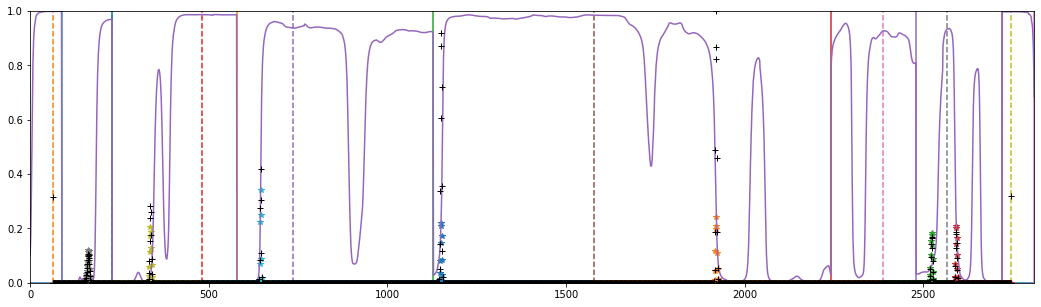

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

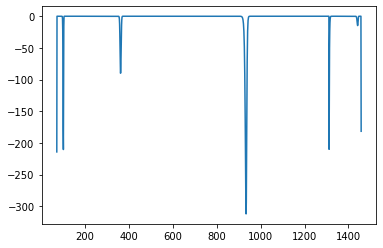

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

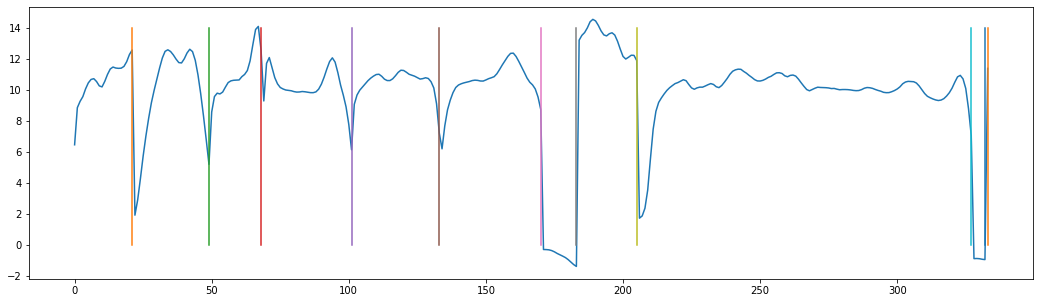

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])